# This is the ML Part

So first of all the files need to be loaded from the Data Base

Following is the Calculation of the Influence Score, that needs a swell value. This has to be done by looking up the numbers calculated. 

Third is choosing the number of Clusters

and finally I can Score the Offer types against the Clusters and see how they differ.

In [2]:
import numpy as np
import pandas as pd
import math
import json
from matplotlib import pyplot as plt
import seaborn as sns

from datetime import datetime


import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
from kmodes.kprototypes import KPrototypes



from scipy import interpolate

import sqlite3
from sqlalchemy import create_engine

In [3]:
engine = create_engine('sqlite:///data/data.db')


portfolio = pd.read_sql_table ('portfolio', engine)
profile = pd.read_sql_table ('profiles', engine)


In [4]:
received_reaction_matrix = pd.read_sql_table ('received_reaction_matrix', engine)
transcript = pd.read_sql_table ('transcript', engine)

In [5]:
# since I had to save everything as string-type, I do have to reformat the types

transcript ['time in hours'] = transcript['time in hours'].astype (int)
transcript ['amount'] = transcript['amount'].astype (float)
transcript ['count'] = transcript['count'].astype (int)
transcript ['expiration'] = transcript['expiration'].astype (int)
transcript ['DayOfWeek'] = transcript['DayOfWeek'].astype (int)
transcript ['WeekOfMonth'] = transcript['WeekOfMonth'].astype (int)
transcript ['DayOfMonth'] = transcript['DayOfMonth'].astype (int)

received_reaction_matrix ['time in hours'] = received_reaction_matrix['time in hours'].astype (int)
received_reaction_matrix ['amount'] = received_reaction_matrix['amount'].astype (float)
received_reaction_matrix ['count'] = received_reaction_matrix['count'].astype (int)
received_reaction_matrix ['expiration'] = received_reaction_matrix['expiration'].astype (int)
received_reaction_matrix ['DayOfWeek'] = received_reaction_matrix['DayOfWeek'].astype (int)
received_reaction_matrix ['WeekOfMonth'] = received_reaction_matrix['WeekOfMonth'].astype (int)
received_reaction_matrix ['DayOfMonth'] = received_reaction_matrix['DayOfMonth'].astype (int)
received_reaction_matrix ['viewed_yn'] = received_reaction_matrix ['viewed_yn'].astype (int)
received_reaction_matrix ['viewtoexpire'] = received_reaction_matrix ['viewtoexpire'].astype (int)
received_reaction_matrix ['completed_yn'] = received_reaction_matrix ['completed_yn'].astype (int)
received_reaction_matrix ['compacttime'] = received_reaction_matrix ['compacttime'].astype (int)
received_reaction_matrix ['completed_yn_unknown'] = received_reaction_matrix ['completed_yn_unknown'].astype (int)
received_reaction_matrix ['index_received'] = received_reaction_matrix ['index_received'].astype (int)
received_reaction_matrix ['index_completed'] = received_reaction_matrix ['index_completed'].astype (int)
received_reaction_matrix ['index_viewed'] = received_reaction_matrix ['index_viewed'].astype (int)
received_reaction_matrix ['visits_count'] = received_reaction_matrix ['visits_count'].astype (int)

transcript = transcript.set_index ('index')
received_reaction_matrix = received_reaction_matrix
received_reaction_matrix.rename (columns = {'person_x': 'person', 'offer_id_x': 'offer_id'}, inplace = True)

In [6]:
transcript.merge (received_reaction_matrix.set_index ('index_completed').drop ([-1]), left_index = True, right_index = True, how = 'left')


,person_x,event_x,time in hours_x,amount_x,count_x,0b1e1539f2cc45b7b9fa7c272da2e1d7_x,2298d6c36e964ae4a3e7e9706d1fb8c2_x,2906b810c7d4411798c6938adc9daaa5_x,3f207df678b143eea3cee63160fa8bed_x,4d5c57ea9a6940dd891ad53e9dbe8da0_x,...,offer_id_y,person_y,viewed_yn,viewtoexpire,completed_yn,compacttime,completed_yn_unknown,index_received,index_viewed,visits_count
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,0.00,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0.00,0,1,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,0.00,0,0,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,0.00,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,0.00,0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,1.59,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,9.53,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,714,3.61,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,3.53,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
transactions.merge (received_reaction_matrix, left_index = True, right_index = True, how  = 'inner')
transactions.merge (received_reaction_matrix, 
                    left_index = True, right_index = True, how  = 'inner')['completed_yn_unknown'].value_counts()

In [ ]:
transactions.merge (received_reaction_matrix, 
                    left_index = True, right_index = True, how  = 'inner')['offer_type_y'].value_counts()

# x.1 Functions

In [8]:
def split_on_event (data):

    '''
        Spliting the data set for better performance

    '''

    received = data [data ['event'] == 'offer received']

    viewed = data [data ['event'] == 'offer viewed']

    completed = data [data ['event'] == 'offer completed']

    transactions = data [data ['event'] == 'transaction']

    return received, viewed, completed, transactions


def offer_per_person (offer_type):
    
    reactions = received_reaction_matrix [received_reaction_matrix ['offer_type'] == offer_type]
    offers = received [received ['offer_type'] == offer_type].groupby ('person')['DayOfMonth'].value_counts ().to_frame().unstack().fillna (0)

    auswahl = ['viewed_yn', 'completed_yn',
           'completed_yn_unknown', 'visits_count']



    offers = offers.merge (reactions.groupby ('person_x')[auswahl].sum(), left_on = offers.index, 
                               right_on =reactions.groupby ('person_x')[auswahl].sum().index).sort_values ('visits_count', ascending = False)
    
    return offers

## Feature Design

Calculating the Influence Score



In [9]:
def get_offer_influence_score (i):
    
    '''
        The influence score of each offer should tell me,
        whether one is likely influenced or is not.
        
        5 terms where calculated
        
        This one is not in the ETL Part, because it can be adjusted and has to be discussed!
    
    '''
    
    try: 
        index_received = i
        person = received_reaction_matrix.set_index ('index_received').loc [i] ['person']
        offer_id = received_reaction_matrix.set_index ('index_received').loc [i] ['offer_id']
        m = received_reaction_matrix.set_index ('index_received').loc [i] ['completed_yn']
        index_completed_return = received_reaction_matrix.set_index ('index_received').loc [i] ['index_completed']
        '''
            If an offer is not completed, there is no need to walk through those steps
        '''        
       
    except: 
        m = 0
        index_completed_return = -99
        
    
    try: 
        '''
            This term is for those customers, that are not part of the interquartile range,
            or for another reason are dropped.
            
        '''
        profile.set_index (['id']).loc [person]['count']
        m = received_reaction_matrix.set_index ('index_received').loc [i] ['completed_yn']
        index_completed_return = received_reaction_matrix.set_index ('index_received').loc [i] ['index_completed']
    except:
        m = 0
        index_completed_return = -66
        
        '''
            code: -66 person not in profiles- dropped out maybe because of interquartile range
        '''

    
    if m == 1:
        
        '''
            Offer is seen and completed - calculating all the terms
        '''
            
        try: offers_pPerson_received = received [received ['person'] == person].count ()['person']
        except: offers_pPerson_received = 1
    
        try: offers_pPerson_viewed = viewed [viewed ['person'] == person].count ()['person']
        except: offers_pPerson_viewed = 0
            
        count_visits_each_customer = profile.set_index ('id').loc [person]['count']
    
        offer_amount =  portfolio.set_index ('id').loc [offer_id]['difficulty']
        offer_expiration = portfolio.set_index ('id').loc [offer_id]['duration']*24
        median_amount = profile.set_index ('id').loc [person]['50%']
    
        off_react_time = received_reaction_matrix.set_index ('index_received').loc [index_received] ['compacttime']
        view_to_expire = received_reaction_matrix.set_index ('index_received').loc [index_received] ['viewtoexpire']
    
        visits_count = received_reaction_matrix.set_index ('index_received').loc [index_received] ['visits_count']
        
        
        '''
            Term 1: intress in offers
            Offers viewed / Offers received
            
            setting a max for this value at 3
        '''
        try: 
            interest = offers_pPerson_viewed / (offers_pPerson_received * 0.75)
            interest = min (2, interest)
            interest = max (0, interest)
        except: freq_visits = 0
        
        
        '''
            Term 2: Percentage money more spent on the offer than median
            
            
        '''
        try: 
            overpay = (offer_amount / (median_amount * 0.66))
            overpay = min (2, overpay)
        except: overpay = 0
        

        
        
        
        '''
            Term 3: attractiveness
            
        '''
        try: 
            attractiveness = (view_to_expire * 0.25) / off_react_time 
            attractiveness = min (2, attractiveness)
            attractiveness = max (0, attractiveness)
        except: attractiveness = 0
       
    
    
        '''
            Term 4: fulfill_by_incident
            the more visits between recognizing the offer and completing it,
            the more unattracted those visits are by the offer itself.
            
        '''
        
        try: 
            fulfill_by_coincident = 1 / (1 * visits_count)
        except: 
            fulfill_by_coincident = 1
        fulfill_by_coincident = min (fulfill_by_coincident, 1)
    
    
        try: influence_score = interest * overpay * attractiveness
        except: influence_score = 0
    
        influence_score_vect = [interest, overpay, attractiveness]

    else: 
        fulfill_by_coincident = 0
        influence_score_vect = [0, 0, 0]
    
        
    return index_completed_return, fulfill_by_coincident, influence_score_vect

In [10]:
received, viewed, completed, transactions = split_on_event (transcript)

In [11]:
# Calculating the Vector

influence_vect = []
influence_incident = []
influence_ind = []


offer_index = received_reaction_matrix.set_index ('index_received') [received_reaction_matrix.set_index ('index_received') ['completed_yn'].astype (int) == 1].index


i = 0
stop = len (offer_index)

while i < stop:
    
    n = offer_index [i]
    
    index_completed, fulfill_by_coincident, influence_score_vect = get_offer_influence_score (n)
    influence_vect.append (influence_score_vect)
    influence_incident.append (fulfill_by_coincident)
    influence_ind.append (index_completed)
    
    
    print ('%.2f' % (i*100 / stop ), end = '\r')
    
    i += 1


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:117: RuntimeWarning: divide by zero encountered in long_scalars


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: divide by zero encountered in double_scalars


KeyboardInterrupt: 

In [ ]:
influence_feature = pd.DataFrame (influence_ind, columns = ['index completed']).merge (
    pd.DataFrame (influence_vect).merge (pd.DataFrame (influence_incident, columns = ['coincidence_scal'])
                                         , left_index = True, right_index = True)
                                            , left_index = True, right_index = True)

influence_feature.to_sql ('influence_feature' ,engine, if_exists = 'replace')

In [ ]:
transactions.amount.describe()

In [12]:
influence_feature = pd.read_sql_table ('influence_feature', engine)

In [71]:
influence_ind = list (influence_feature['index completed'])

In [13]:
pd.DataFrame(influence_vect).describe()

,0,1,2
count,11463.000000,11463.000000,11463.000000
mean,1.049239,0.995788,0.928010
std,0.364722,0.606260,0.783164
min,0.000000,0.000000,0.000000
25%,0.888889,0.568690,0.263158
50%,1.111111,0.826983,0.687500
75%,1.333333,1.430039,2.000000
max,1.333333,2.000000,2.000000


In [14]:
scalar2 = []

influence_vect = influence_feature [['0', '1', '2']]
influence_incident = influence_feature ['coincidence_scal']

i = 0
while i < len (influence_vect):
    y = 1
    for x in pd.DataFrame(influence_vect).iloc [i].sort_values (ascending = False)[:2]:
        y = y * x * pd.DataFrame (influence_incident).iloc [i]
    scalar2.append (y)
    
    print ('%.2f' % (i*100 / len (influence_vect) ), end = '\r')
    
    i += 1

In [15]:
pd.DataFrame(scalar2).describe()

,coincidence_scal
count,23999.000000
mean,1.501579
std,0.977163
min,0.000000
25%,0.706364
50%,1.359833
75%,2.222222
max,4.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f92f5d83bd0>]],
      dtype=object)

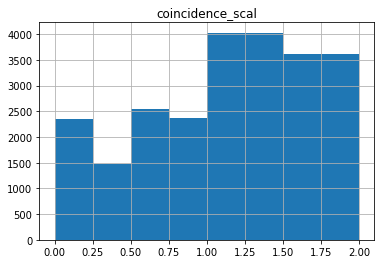

In [16]:
pd.DataFrame(scalar2).hist(bins = [0, 0.25, 0.5, 0.75, 1, 1.5, 2])

In [17]:
influence_feature2 = influence_feature.merge (pd.DataFrame(scalar2)
                         , left_index = True, right_index = True).rename (
    columns = {'coincidence_scal_x': 'coincidence_scal', 'coincidence_scal_y': 'influence scalar'})

In [18]:
received_reaction_matrix.set_index ('index_received') [received_reaction_matrix.set_index ('index_received') ['completed_yn'].astype (int) == 1].reset_index ().merge (influence_feature2, left_index = True, right_index = True).columns



Index(['index_received', 'index_x', 'person', 'event', 'time in hours',
       'amount', 'count', '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '2298d6c36e964ae4a3e7e9706d1fb8c2', '2906b810c7d4411798c6938adc9daaa5',
       '3f207df678b143eea3cee63160fa8bed', '4d5c57ea9a6940dd891ad53e9dbe8da0',
       '5a8bc65990b245e5a138643cd4eb9837', '9b98b8c7a33c4b65b9aebfe6a799e6d9',
       'ae264e3637204a6fb9bb56bc8210ddfd', 'f19421c1d4aa40978ebb69ca19b0e20d',
       'fafdcd668e3743c1bb461111dcafc2a4', 'offer_id', 'expiration',
       'offer_type', 'DayOfWeek', 'WeekOfMonth', 'DayOfMonth', 'offer_id_y',
       'person_y', 'viewed_yn', 'viewtoexpire', 'completed_yn', 'compacttime',
       'completed_yn_unknown', 'index_viewed', 'index_completed',
       'visits_count', 'index_y', 'index completed', '0', '1', '2',
       'coincidence_scal', 'influence scalar'],
      dtype='object')

In [19]:
received_reaction_matrix ['completed_yn_unknown'].value_counts()

0    51166
1     5200
Name: completed_yn_unknown, dtype: int64

In [20]:
columns = ['index_received', 'index_x', 'person', 'event', 'time in hours',
       'amount', 'count', 'index_completed', 'index completed', '0', '1', '2',
       'coincidence_scal', 'influence scalar', 'offer_type', 'offer_id', 'expiration', 'viewed_yn', 'viewtoexpire', 'completed_yn', 'compacttime',
       'completed_yn_unknown', 'index_viewed', 'amount']

received_reaction_matrix2 = received_reaction_matrix.set_index ('index_received') [received_reaction_matrix.set_index ('index_received') ['completed_yn'].astype (int) == 1].reset_index ().merge (influence_feature2, left_index = True, right_index = True)[columns]




In [21]:
# merge 

# influence score
influence_feature2 = influence_feature.merge (pd.DataFrame(scalar2)
                         , left_index = True, right_index = True).rename (
    columns = {'coincidence_scal_x': 'coincidence_scal', 'coincidence_scal_y': 'influence scalar'})


# received reaction matrix
columns = ['index_completed', '0', '1', '2', 'index completed',
       'coincidence_scal', 'influence scalar']

received_reaction_matrix2 = received_reaction_matrix.set_index ('index_received') [received_reaction_matrix.set_index ('index_received') ['completed_yn'].astype (int) == 1].reset_index ().merge (influence_feature2, left_index = True, right_index = True)[columns]

received_reaction_matrix3 = received_reaction_matrix.set_index ('index_completed').merge (received_reaction_matrix2.set_index ('index_completed'), left_index = True, right_index = True, how = 'outer')



# transactions

columns = ['index_received',  'index completed',  '0', '1', '2',
       'coincidence_scal', 'influence scalar', 'offer_type', 'offer_id', 'expiration', 'viewed_yn', 'viewtoexpire', 'completed_yn',
       'compacttime', 'completed_yn_unknown', 'index_viewed']
transcript2 = transcript.merge(received_reaction_matrix3[columns], left_index = True, right_index = True, how = 'left').fillna (0)




# Clustering

I assume that different clusters react to different offer types better or worse


In [22]:
from sklearn import preprocessing

profiles_normalized = profile
Num_features= ['age', 'income', 'member_x_weeks']
profiles_normalized[Num_features]=preprocessing.MinMaxScaler().fit_transform(profiles_normalized[Num_features])

# set the data-types:

profiles_normalized ['gender'] = profiles_normalized.gender.astype (object)
profiles_normalized ['age'] = profiles_normalized.age.astype (float)
profiles_normalized ['id'] = profiles_normalized.id.astype (object)

profiles_normalized ['F'] = profiles_normalized.F.astype (object)
profiles_normalized ['M'] = profiles_normalized.M.astype (object)
profiles_normalized ['O'] = profiles_normalized.O.astype (object)
profiles_normalized ['member_x_weeks'] = profiles_normalized.member_x_weeks.astype (float)

profiles_normalized ['income'] = profiles_normalized.income.astype (float)

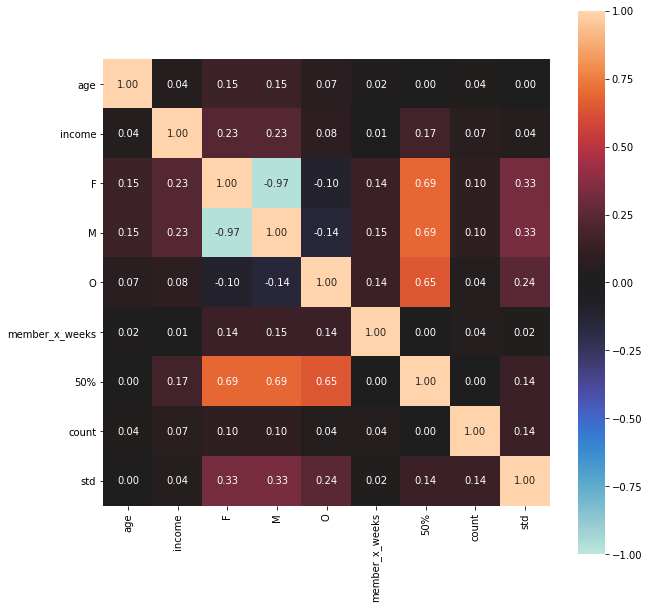

In [23]:
from dython.model_utils import roc_graph
from dython.nominal import associations

def associations_example():
    associations(Data_Correlation, nominal_columns=['age','member_x_weeks', 'income', '50%', 'count', 'std'])
    
    
# data correlation analyzis:


Data_Correlation=profiles_normalized.loc[:, ['age', 'income', 'F', 'M', 'O', 'member_x_weeks', '50%', 'count', 'std']]

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=10, 10
associations_example()

In [24]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) # heuristic from article [1]
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [25]:
Data = profiles_normalized [['member_x_weeks', 'income', 'age', '50%', 'count', 'std']]

#Use a random sample of Data for faster computation
#Resetting the indexs
Data=Data.reset_index(drop=True)
#Rename the levels within in the CancellationCode column

Data.columns

#Checking whether data can be clustered
Num_features =Data.select_dtypes(include=[np.number]).columns
hopkins(Data[Num_features])

0.913147011547997

Hopkins Value is signalizing that the Data is not randomly spread,
and is likely to be clustered

Using the Principal Components Analyzes:

In [27]:
from sklearn.decomposition import PCA

cols = ['age', 'income', 'member_x_weeks', '50%', 'count', 'std']

Data_pca= profiles_normalized [cols]
print (Data_pca.dtypes)

#Principal Component

pca = PCA(n_components= 'mle', whiten=True)

Num_features=Data_pca.select_dtypes(include=[np.number]).columns

x=Data_pca[Num_features]
principalComponents = pca.fit_transform(x)

# Cumulative Explained Variance
cum_explained_var = []
for i in range(0, len(pca.explained_variance_ratio_)):
    if i == 0:
        cum_explained_var.append(pca.explained_variance_ratio_[i])
    else:
        cum_explained_var.append(pca.explained_variance_ratio_[i] + 
                                 cum_explained_var[i-1])

print(cum_explained_var)

age               float64
income            float64
member_x_weeks    float64
50%               float64
count             float64
std               float64
dtype: object
[0.7135251647595536, 0.9684986077051903, 0.9986000103908103, 0.9991773235098838, 0.999732623820703]


In [30]:
#Principal Components converted to a Data frame


principalDf  = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4', 'principal component 5'])
principalDf.shape


profiles_pca = pd.concat ([principalDf, profiles_normalized.reset_index()[['F', 'M', 'O', 'index']]], axis = 1)

profiles_pca['F'] = profiles_pca['F'].astype (int)
profiles_pca['M'] = profiles_pca['M'].astype (int)
profiles_pca['O'] = profiles_pca['O'].astype (int)

<function matplotlib.pyplot.show(*args, **kw)>

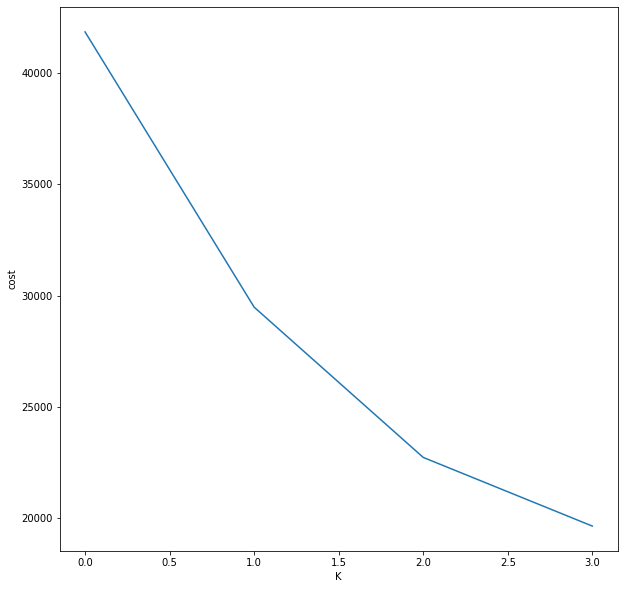

In [1277]:
# Attention -- time consuming calculation

from kmodes.kprototypes import KPrototypes

#Choosing optimal K value
cost = []
X = profiles_pca[['principal component 1', 'principal component 2',
                  'principal component 3', 'principal component 4', 'F', 'M', 'O']]
for num_clusters in list(range(2,10, 2)):
    kproto = KPrototypes(n_clusters=num_clusters, init='Huang', random_state=42,n_jobs=-2,max_iter=15,n_init=50) 
    kproto.fit_predict(X, categorical=[4, 5, 6])
    cost.append(kproto.cost_)

plt.plot(cost)
plt.xlabel('K')
plt.ylabel('cost')
plt.show

Choosing the right amount of Clusters. 

I use the elbow method: and I end up with 8 (that is K equal to 2)

The number should be as small as possible

In [52]:
data = profiles_pca

from sklearn.model_selection import train_test_split


x_train ,x_test = train_test_split(data,test_size=0.2) 

1    2301
4    2275
3    1460
0    1415
2    1154
5     852
Name: Cluster_id, dtype: int64


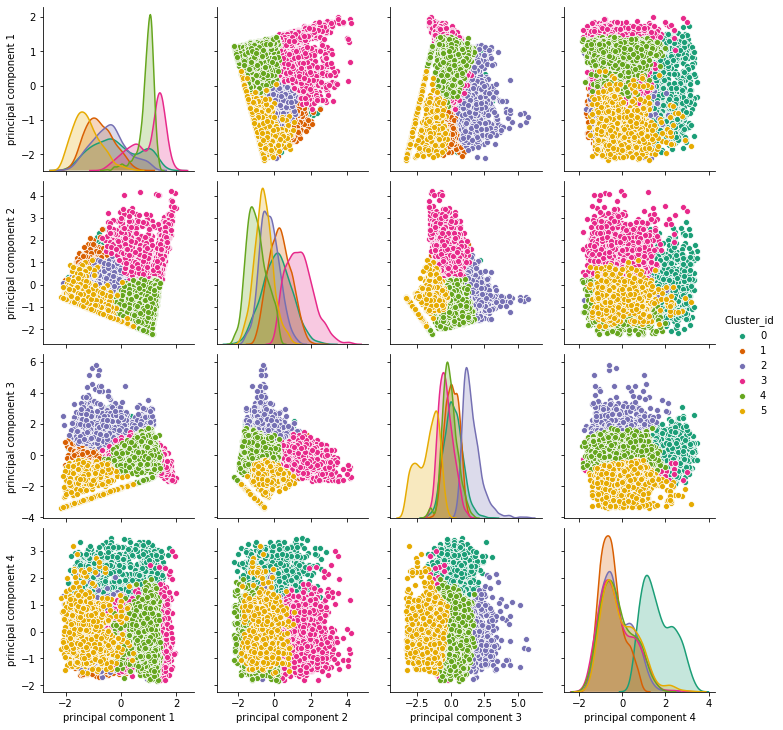

In [53]:
from kmodes.kprototypes import KPrototypes

# number of clusters
k = 6

kproto = KPrototypes(n_clusters=k, init='Huang', verbose=0, random_state=42,max_iter=20, n_init=50,n_jobs=-2,gamma=.25) 
clusters = kproto.fit_predict(x_train[['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4', 
                                 'F', 'M', 'O']], 
                              categorical =[4, 5, 6])

df=pd.DataFrame(x_train)
df['Cluster_id']=clusters
clustering = df [['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4', 'Cluster_id']]
print(df['Cluster_id'].value_counts())
sns.pairplot(clustering,hue='Cluster_id',palette='Dark2',diag_kind='kde')

In [54]:
clustering ['train_test'] = np.zeros (len (clustering))
clustering

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,principal component 1,principal component 2,principal component 3,principal component 4,Cluster_id,train_test
3821,-1.421096,-0.517216,2.155165,1.214923,2,0.0
480,-0.470409,-0.248709,-0.681404,-0.708139,1,0.0
9376,1.145414,-1.734229,-0.422972,-1.351040,4,0.0
10034,0.562798,-1.416540,-0.059693,0.029930,4,0.0
8546,0.141606,0.346956,0.410285,-1.178616,1,0.0
...,...,...,...,...,...,...
9719,-1.185186,0.005049,1.912718,-0.623266,2,0.0
1555,-0.024663,0.661885,0.681524,1.567757,0,0.0
9965,-0.395387,0.202340,0.725506,2.188825,0,0.0
10572,0.944602,-0.981821,-0.595223,1.300168,4,0.0


clustering - columns 2: test yn
test : 0

1    567
4    539
3    382
0    363
2    278
5    236
Name: Cluster_id, dtype: int64


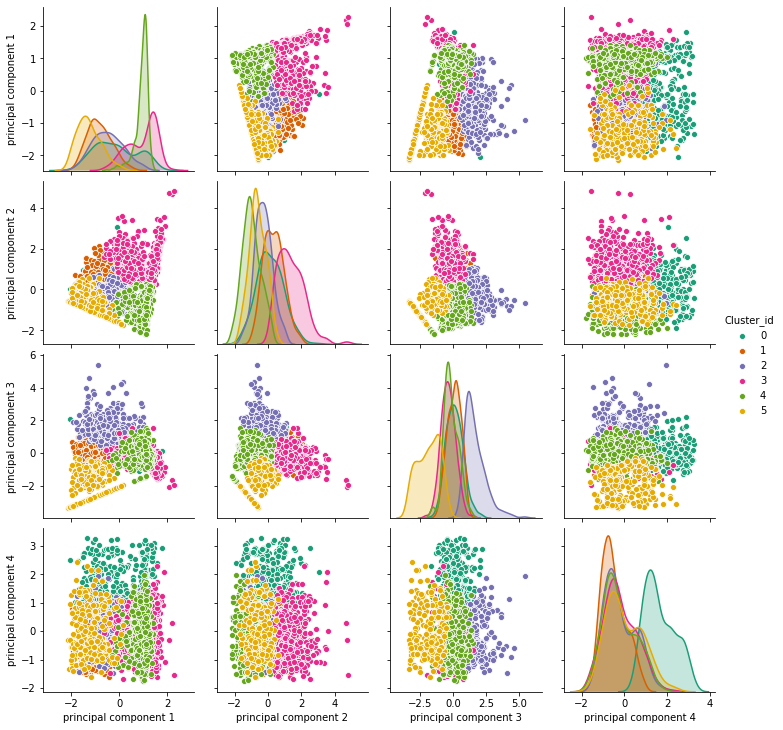

In [55]:
# predicting the test clusters
clusters = kproto.predict(x_test[['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4', 
                                 'F', 'M', 'O']], 
                              categorical =[4, 5, 6])

df=pd.DataFrame(x_test)
df['Cluster_id']=clusters
clustering_test = df [['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4', 'Cluster_id']]
print(df['Cluster_id'].value_counts())
sns.pairplot(clustering_test,hue='Cluster_id',palette='Dark2',diag_kind='kde')

In [56]:
# adding 1 for identification of the test profiles
clustering_test['train_test'] = np.ones (len (clustering_test))
clustering_test

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,principal component 1,principal component 2,principal component 3,principal component 4,Cluster_id,train_test
8740,-1.287489,-0.059920,-1.157045,-0.793439,5,1.0
10903,-0.248942,-0.253620,2.180934,-0.952227,2,1.0
3958,-1.251546,0.395706,-0.171444,-0.339546,1,1.0
7622,-1.244184,-0.562928,3.359775,-0.544126,2,1.0
1080,-0.429406,-1.424797,-2.340642,-1.024678,5,1.0
...,...,...,...,...,...,...
1875,-0.582284,0.927861,0.055038,-0.817089,1,1.0
1061,-0.571948,2.235322,0.165551,0.279374,3,1.0
8265,1.143992,-1.096125,-0.882139,1.426397,4,1.0
5215,-0.795905,-0.625769,2.121777,-0.521804,2,1.0


In [58]:
clustering = clustering.append (clustering_test)

In [79]:
clustering

,principal component 1,principal component 2,principal component 3,principal component 4,Cluster_id,train_test
3821,-1.421096,-0.517216,2.155165,1.214923,2,0.0
480,-0.470409,-0.248709,-0.681404,-0.708139,1,0.0
9376,1.145414,-1.734229,-0.422972,-1.351040,4,0.0
10034,0.562798,-1.416540,-0.059693,0.029930,4,0.0
8546,0.141606,0.346956,0.410285,-1.178616,1,0.0
...,...,...,...,...,...,...
1875,-0.582284,0.927861,0.055038,-0.817089,1,1.0
1061,-0.571948,2.235322,0.165551,0.279374,3,1.0
8265,1.143992,-1.096125,-0.882139,1.426397,4,1.0
5215,-0.795905,-0.625769,2.121777,-0.521804,2,1.0


In [59]:
profiles = profile.merge (clustering, left_index = True, right_index = True)

# x.2 Functions

In [60]:
def influence_scalar_to_binary (swell_value):
    
    '''
        Decide on what swell the transaction is called influenced
    '''

    i = 0

    influence_yn = []

    while i < len (influence_DF):
        if influence_DF.loc [i][0] >= swell_value:
            influence_yn.append (1)
        else:
            influence_yn.append (0)
        i += 1

    
    influence_bin = influence_DF.merge (pd.DataFrame(influence_yn), left_index = True, right_index = True)
    return influence_bin

In [62]:
def add_clusters (data):
    
    '''
        Add the found clusters to the transcript
        
        99 is the cluster for not indentified persons.
    '''
    
    i = 0
    cluster = []
    train_test = []
    stop = len (data)
    
    while i < stop:
        
        try: 
            cluster.append (profiles.set_index (['id']).loc [data.iloc [i]['person']] ['Cluster_id'])
            train_test.append (profiles.set_index (['id']).loc [data.iloc [i]['person']] ['train_test'])
        except: 
            cluster.append (99)
            train_test.append (99)
        
        i += 1
        print ('%.2f' % (i*100 / stop ), end = '\r')
    
    return cluster, train_test





# Choose a swell value!!

In [63]:
influence_DF = pd.DataFrame(scalar2)

In [72]:
# Choosing a swell value for the scalar.
# I take the Product of the mean values -> something around 1

swell_value = 1

influence_bin = influence_scalar_to_binary (swell_value)
influence_bin['index'] = influence_ind
influence_bin = influence_bin.set_index ('index')

In [73]:
influence_bin

,coincidence_scal,0
index,,
47582,0.485509,0
32625,0.897070,0
218401,0.596370,0
25737,4.000000,1
46599,1.261050,1
...,...,...
271093,2.222222,1
263920,2.666667,1
289101,2.666667,1


In [74]:
transcript3 = transcript2.merge (influence_bin, left_index = True, right_index = True, how = 'left')
transcript3.rename (columns = {0: 'influence bin'}, inplace = True)

In [75]:
transcript3['influence bin'].value_counts()

1.0    21830
0.0    11515
Name: influence bin, dtype: int64

# Add Clusters to the trancsript values

In [77]:
profiles_pca

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,F,M,O,index
0,-1.140726,0.100060,-0.666864,-1.124024,0.772692,1,0,0,1
1,-0.955424,-0.665622,-1.071313,-0.590347,0.370482,0,1,0,2
2,-0.123485,-1.051245,0.155853,1.738839,1.144559,0,1,0,3
3,0.794309,-1.300208,0.432652,-0.611874,0.374819,0,1,0,4
4,-0.170433,-0.344057,0.897608,-0.372800,0.303203,1,0,0,5
...,...,...,...,...,...,...,...,...,...
11817,-1.466332,0.053419,-0.632303,-0.955421,-0.421472,1,0,0,12564
11818,0.793539,1.089790,0.193626,-1.345867,0.756146,0,1,0,12565
11819,-1.549566,-0.054466,1.114659,-1.384742,0.379514,0,1,0,12566
11820,1.698148,2.739634,-1.357067,0.624319,0.847219,0,1,0,12568


In [83]:
profiles

,index,gender,age,id,became_member_on,income,F,M,O,member_x_weeks,...,50%,75%,max,std,principal component 1,principal component 2,principal component 3,principal component 4,Cluster_id,train_test
0,1,F,0.800000,78afa995795e4d85b5d9ceeca43f5fef,20170509,0.897436,1,0,0,0.091954,...,20.805,23.3775,26.56,3.20,-1.140726,0.100060,-0.666864,-1.124024,1,0.0
1,2,M,0.700000,e2127556f4f64592b11af22de27a7932,20180426,0.512821,0,1,0,0.176245,...,18.420,19.9250,21.43,1.91,-0.955424,-0.665622,-1.071313,-0.590347,5,0.0
2,3,M,0.657143,389bc3fa690240e798340f5a15918d5c,20180209,0.294872,0,1,0,0.739464,...,11.260,13.4450,15.63,3.13,-0.123485,-1.051245,0.155853,1.738839,0,1.0
3,4,M,0.557143,2eeac8d8feae4a8cad5a6af0499a211d,20171111,0.269231,0,1,0,0.176245,...,3.805,5.7525,7.14,2.83,0.794309,-1.300208,0.432652,-0.611874,4,0.0
4,5,F,0.600000,aa4862eba776480b8bb9c68455b8c2e1,20170911,0.346154,1,0,0,0.222222,...,12.445,15.1025,23.30,4.84,-0.170433,-0.344057,0.897608,-0.372800,2,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11817,12564,F,0.585714,8f5146270f5745d4862514da8a7b6620,20180504,0.576923,1,0,0,0.045977,...,23.250,23.6700,26.78,3.43,-1.466332,0.053419,-0.632303,-0.955421,1,0.0
11818,12565,M,0.685714,09a232cdf36d4d2b9d23a860493ce998,20170916,0.076923,0,1,0,0.030651,...,7.130,9.8750,17.46,4.00,0.793539,1.089790,0.193626,-1.345867,3,1.0
11819,12566,M,0.771429,6a8b0facbdf34e45bbf6d1f82fa6fc79,20160622,0.769231,0,1,0,0.007663,...,23.400,26.4500,26.72,6.28,-1.549566,-0.054466,1.114659,-1.384742,2,1.0
11820,12568,M,0.471429,acd96146258741999a42ce74856bc119,20140201,0.333333,0,1,0,0.478927,...,2.720,3.6400,8.64,1.96,1.698148,2.739634,-1.357067,0.624319,3,1.0


In [84]:
received, viewed, completed, transactions = split_on_event (transcript3)

In [85]:
transactions1 = add_clusters (transactions)



In [93]:
received1  = add_clusters (received)


In [91]:
# add clusters  
analyzes_DF = transactions.reset_index().merge (pd.DataFrame (transactions1, index = {'cluster', 'train_test'}).T, left_index = True, right_index = True)


In [94]:
received_a = received.reset_index().merge (pd.DataFrame (received1, index = {'cluster', 'train_test'}).T, left_index = True, right_index = True)



# Start of Evaluation

In [95]:
def  get_cluster_desc  (cluster, data):
    
    
    DF = data [data ['cluster']== cluster] [
           data [data ['cluster']== cluster]['completed_yn'] == 1]
    
    
    
    offer_type = 'bogo'
    
    bogo_infl = DF[DF ['offer_type_y'] == offer_type][
             DF[DF['offer_type_y'] == offer_type]['influence bin'] ==1
             ]['amount'].describe()
    
    bogo_noinfl = DF[DF ['offer_type_y'] == offer_type][
             DF[DF['offer_type_y'] == offer_type]['influence bin'] == 0 
             ]['amount'].describe()
    
    offer_type = 'discount'
    
    
    disc_infl = DF[DF ['offer_type_y'] == offer_type][
             DF[DF['offer_type_y'] == offer_type]['influence bin'] ==1
             ]['amount'].describe()
    
    disc_noinfl = DF[DF ['offer_type_y'] == offer_type][
             DF[DF['offer_type_y'] == offer_type]['influence bin'] ==0 
             ]['amount'].describe()   
    
    
    others = data [data ['cluster']== cluster][
        data [data ['cluster']== cluster]['offer_type_y'].isna ()]['amount'].describe()
  


    '''
        unknown completion 
    '''
    
    DF = data [data ['cluster']== cluster] [
           data [data ['cluster']== cluster]['completed_yn_unknown'] == 1]
    
    
 
    offer_type = 'bogo'
    
    
    bogo_unsucc = DF[DF ['offer_type_y'] == offer_type]['amount'].describe()
    
    
    offer_type = 'discount'
    
    disc_unsucc = DF[DF ['offer_type_y'] == offer_type]['amount'].describe()
    
    
    DF = data [data ['cluster']== cluster] [
           data [data ['cluster']== cluster]['completed_yn_unknown'] == 0]
    others2 = DF [DF ['completed_yn'] == 0]['amount'].describe()
    
    # data8 = analyzes_DF [analyzes_DF ['cluster']== cluster][
        # analyzes_DF [analyzes_DF ['cluster']== cluster]['offer_type_y'].isna ()]['amount'].describe()
    
    
    data_bogo = pd.DataFrame (bogo_infl).merge (pd.DataFrame (bogo_noinfl).merge (
        pd.DataFrame(bogo_unsucc), left_index = True, right_index = True)
            ,left_index = True, right_index = True)
    
    
    data_disc = pd.DataFrame (disc_infl).merge (pd.DataFrame (disc_noinfl).merge (
        pd.DataFrame(disc_unsucc), left_index = True, right_index = True)
            ,left_index = True, right_index = True)

        
    
    vect_bogo = pd.DataFrame(['bogo_infl', 'bogo_noinfl', 'bogo_unsucc'])
    vect_disc = pd.DataFrame(['disc_infl', 'disc_noinfl', 'disc_unsucc'])
    
    data_bogo.columns = vect_bogo[0]
    data_disc.columns = vect_disc[0]
    
    return data_bogo, data_disc
    

In [96]:
analyzes_DF['completed_yn_unknown'].value_counts()

0.0    140753
1.0      4597
Name: completed_yn_unknown, dtype: int64

In [100]:
analyzes_DF = analyzes_DF[analyzes_DF ['index'].duplicated () == False]



analyzes_DF_train = analyzes_DF [analyzes_DF ['train_test'] == 0]
analyzes_DF_test = analyzes_DF [analyzes_DF ['train_test'] == 1]

In [101]:
received_a['offer_type_x'].value_counts()

discount         30543
bogo             30499
informational    15235
Name: offer_type_x, dtype: int64

In [122]:
### train test split!!!

received_train = received_a [received_a ['train_test'] == 0]

clusters_bogo_sent = received_train[received_train.offer_type_x == 'bogo']['cluster'].value_counts()

# send out offers each cluster for type BOGO

clusters_disc_sent = received_train[received_train.offer_type_x == 'discount']['cluster'].value_counts()

# send out offers each cluster for type DISCOUNT

In [123]:
i = 0

bogo = []
disc = []

while i < k:
    cluster = i


    data_bogo, data_disc = get_cluster_desc  (cluster, analyzes_DF_train)

    bogo.append (data_bogo.loc ['count']/clusters_bogo_sent.loc [cluster])
    disc.append (data_disc.loc ['count']/clusters_disc_sent.loc [cluster])
    
    i += 1

v = pd.DataFrame ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])  


bogo1 = pd.DataFrame (bogo).T
bogo1.columns = v[0] [0:k]

disc1 = pd.DataFrame (disc).T
disc1.columns = v[0] [0:k]

In [124]:
bogo1

,0,1,2,3,4,5
0,,,,,,
bogo_infl,0.339335,0.396071,0.312532,0.307290,0.073709,0.123725
bogo_noinfl,0.173386,0.223624,0.167612,0.128357,0.022580,0.162475
bogo_unsucc,0.075930,0.080524,0.070655,0.065225,0.036076,0.067301


In [125]:
disc1

,0,1,2,3,4,5
0,,,,,,
disc_infl,0.396036,0.451275,0.353854,0.368772,0.101695,0.153581
disc_noinfl,0.117314,0.127949,0.089089,0.233684,0.063375,0.140496
disc_unsucc,0.126214,0.126519,0.109610,0.134035,0.035372,0.088154


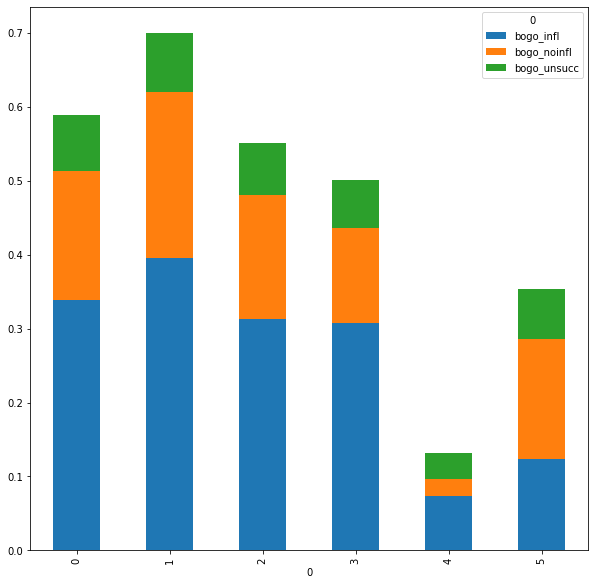

In [107]:
bogo1.T.plot (kind = 'bar', stacked = True)

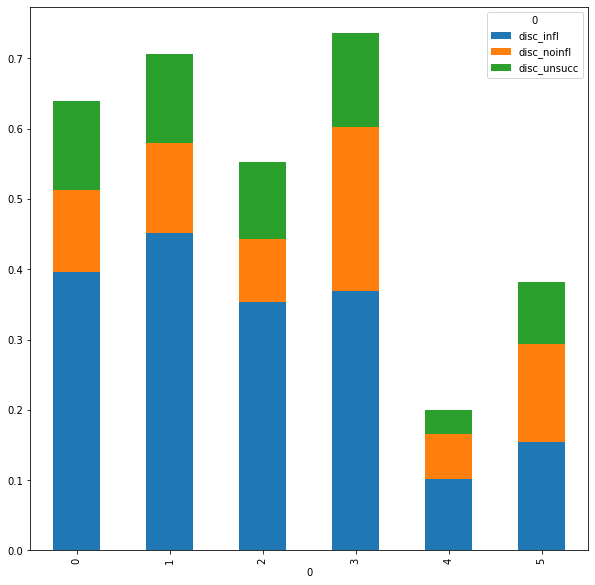

In [108]:
disc1.T.plot (kind = 'bar', stacked = True)

In [110]:
data_bogo, data_disc = get_cluster_desc  (cluster, analyzes_DF_train)
data_bogo

,bogo_infl,bogo_noinfl,bogo_unsucc
count,182.000000,239.000000,99.000000
mean,20.202198,21.355732,21.651818
std,3.956031,3.821801,3.829427
min,9.770000,10.930000,11.220000
25%,17.280000,18.785000,19.030000
50%,19.815000,21.580000,21.910000
75%,23.027500,24.315000,24.845000
max,28.390000,28.380000,28.000000


How many Offers per person were sent?

In [111]:
clusters_bogo_sent/ df['Cluster_id'].value_counts()

1.0    7.271605
4.0    7.148423
3.0    7.505236
0.0    7.038567
2.0    6.974820
5.0    6.233051
dtype: float64

In [112]:
(clusters_disc_sent/ df['Cluster_id'].value_counts()).describe()

count    6.000000
mean     7.094206
std      0.532109
min      6.152542
25%      6.904201
50%      7.294583
75%      7.446079
max      7.552876
dtype: float64

# Model performance

remember I have the train test split data on the clusters.
I will now Perform the evaluation again.

In [113]:
### train test split!!!

received_test = received_a [received_a ['train_test'] == 1]

clusters_bogo_sent = received_test[received_test.offer_type_x == 'bogo']['cluster'].value_counts()

# send out offers each cluster for type BOGO

clusters_disc_sent = received_test[received_test.offer_type_x == 'discount']['cluster'].value_counts()

# send out offers each cluster for type DISCOUNT

In [117]:
i = 0

bogo = []
disc = []

while i < k:
    cluster = i


    data_bogo, data_disc = get_cluster_desc  (cluster, analyzes_DF_test)

    bogo.append (data_bogo.loc ['count']/clusters_bogo_sent.loc [cluster])
    disc.append (data_disc.loc ['count']/clusters_disc_sent.loc [cluster])
    
    i += 1

v = pd.DataFrame ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])  


bogo2 = pd.DataFrame (bogo).T
bogo2.columns = v[0] [0:k]

disc2 = pd.DataFrame (disc).T
disc2.columns = v[0] [0:k]

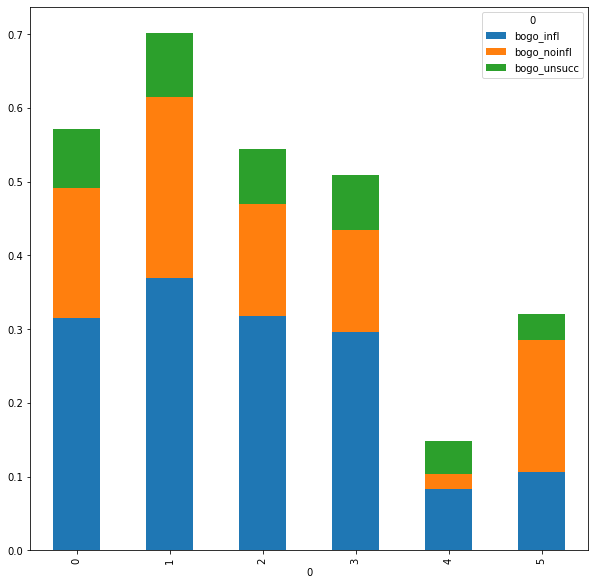

In [118]:
bogo2.T.plot (kind = 'bar', stacked = True)

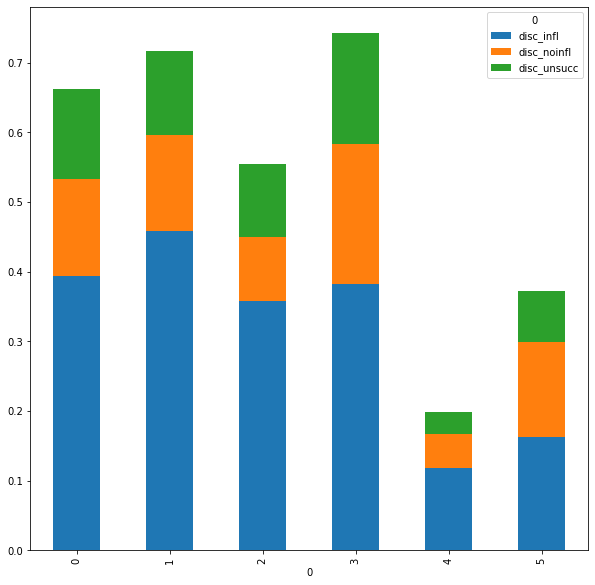

In [119]:
disc2.T.plot (kind = 'bar', stacked = True)

In [128]:
# R Squared Discount

from sklearn.metrics import r2_score


y_true = disc1
y_pred = disc2
r2_score(y_true, y_pred, sample_weight=None, multioutput='uniform_average')

0.9248150722607739

In [129]:
# R Squared BOGO

y_true = bogo1
y_pred = bogo2
r2_score(y_true, y_pred, sample_weight=None, multioutput='uniform_average')

0.9131206721674622

In [130]:
# you can discuss if this is too high and the model may be overfitted